<a href="https://colab.research.google.com/github/BristonDomino/Briston-Final-project-Machine-Learning-Class-CNN/blob/main/Briston_Final_project_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Statements and Setup

In [ ]:
# Script1
# The Keras library provides support for neural networks and deep learning
# Use the updated Keras library from Tensorflow -- provides support for neural networks and deep learning
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten, Input
import keras.optimizers
import matplotlib.pyplot as plt

from keras.callbacks import ReduceLROnPlateau

from  google.colab import drive
drive.mount('/content/drive')

PROJECT_DIR = '/content/drive/MyDrive/Spring 2023/Machine Learning/Final project'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

Setup generators

In [ ]:
# Read data from the folders

caltech256_validate_folder = f'{PROJECT_DIR}/Caltech_256/test'
caltech256_train_folder = f'{PROJECT_DIR}/Caltech_256/train'
caltech20_validate_folder = f'{PROJECT_DIR}/Caltech_20/test_resized_20catagories'
caltech20_train_folder = f'{PROJECT_DIR}/Caltech_20/train_resized_20catagories'

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        # rotation_range=10,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        rescale=1./255,
        # shear_range=0.1,
        # zoom_range=0.1,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 8
# batch_size = 30
# batch_size = 32  # This might take too much memory

# this is a generator that will read pictures found in
# sub folders of 'data/train', and indefinitely generate
# batches of augmented image data
caltech256_train_generator = train_datagen.flow_from_directory(
        caltech256_train_folder,  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=batch_size,
        color_mode="rgb",
        class_mode='categorical'  # since we use binary_crossentropy loss, we need binary labels
)

# this is a similar generator, for validation data
caltech256_validation_generator = test_datagen.flow_from_directory(
        caltech256_validate_folder,
        target_size=(224, 224),
        batch_size=batch_size,
        color_mode="rgb",
        class_mode='categorical'
)

# this is a generator that will read pictures found in
# sub folders of 'data/train', and indefinitely generate
# batches of augmented image data
caltech20_train_generator = train_datagen.flow_from_directory(
        caltech20_train_folder,  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=batch_size,
        color_mode="rgb",
        class_mode='categorical'  # since we use binary_crossentropy loss, we need binary labels
)

# this is a similar generator, for validation data
caltech20_validation_generator = test_datagen.flow_from_directory(
        caltech20_validate_folder,
        target_size=(224, 224),
        batch_size=batch_size,
        color_mode="rgb",
        class_mode='categorical'
)

training_generator_lookup = {
    True: caltech256_train_generator,
    False: caltech20_train_generator,
}

validation_generator_lookup = {
    True: caltech256_validation_generator,
    False: caltech20_validation_generator,
}

Found 23828 images belonging to 256 classes.
Found 5952 images belonging to 256 classes.
Found 1393 images belonging to 20 classes.
Found 396 images belonging to 20 classes.


Neural network generator functions

In [ ]:
BASELINE_WEIGHTS_FILE = f'{PROJECT_DIR}/baseline_weights.h5'
BASELINE_W_CALTECH256_WEIGHTS_FILE = f'{PROJECT_DIR}/baseline_with_caltech256.h5'
VGG16_VARIANT_FOR_CALTECH20_WEIGHTS_FILE = f'{PROJECT_DIR}/vgg16_variant_for_caltech20.h5'
VGG16_VARIANT_FOR_CALTECH256_WEIGHTS_FILE = f'{PROJECT_DIR}/vgg16_variant_for_caltech256.h5'

file_name_lookup = {
    True: {  # VGG16
        True: VGG16_VARIANT_FOR_CALTECH256_WEIGHTS_FILE,
        False: VGG16_VARIANT_FOR_CALTECH20_WEIGHTS_FILE,
    },
    False: {  # Baseline
        True: BASELINE_W_CALTECH256_WEIGHTS_FILE,
        False: BASELINE_WEIGHTS_FILE,
    },
}

# Baseline CNN of Caltech 20
def create_baseline(load_weights=True, lr=1e-3):
    # Set up the Neural Network
    INPUT_SHAPE = (224, 224, 3)
    OUTPUT_SIZE = 20

    NN = Sequential()
    NN.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE))
    NN.add(Conv2D(8, (3, 3), activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2)))
    NN.add(Conv2D(16, (3, 3), activation='relu'))
    NN.add(Conv2D(16, (3, 3), activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2)))
    NN.add(Conv2D(32, (3, 3), activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2)))
    NN.add(Conv2D(64, (3, 3), activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2)))
    NN.add(Flatten())
    NN.add(Dense(256, activation='relu'))
    NN.add(Dense(OUTPUT_SIZE, activation='softmax'))
    print("Neural Network Model created")
    NN.summary()

    # Compile neural network model
    NN.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    if load_weights:
        NN.load_weights(BASELINE_WEIGHTS_FILE)

    return NN


def create_baseline_with_caltech256(load_weights=True, lr=1e-3):
    # Set up the Neural Network
    INPUT_SHAPE = (224, 224, 3)
    OUTPUT_SIZE = 256

    NN = Sequential()
    NN.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE))
    NN.add(Conv2D(8, (3, 3), activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2)))
    NN.add(Conv2D(16, (3, 3), activation='relu'))
    NN.add(Conv2D(16, (3, 3), activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2)))
    NN.add(Conv2D(32, (3, 3), activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2)))
    NN.add(Conv2D(64, (3, 3), activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2)))
    NN.add(Flatten())
    NN.add(Dense(256, activation='relu'))
    NN.add(Dense(OUTPUT_SIZE, activation='softmax'))
    print("Neural Network Model created")
    NN.summary()

    # Compile neural network model
    NN.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    if load_weights:
        NN.load_weights(BASELINE_W_CALTECH256_WEIGHTS_FILE)

    return NN


def create_vgg16_variant_for_caltech20(load_weights=True, lr=1e-3):
    # Set up the Neural Network
    INPUT_SHAPE = (224, 224, 3)
    OUTPUT_SIZE = 20

    NN = Sequential()
    NN.add(Input(shape=INPUT_SHAPE))
    NN.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    NN.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    NN.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    NN.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    NN.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    NN.add(Flatten())
    NN.add(Dense(4096, activation='relu'))
    NN.add(Dense(4096, activation='relu'))
    NN.add(Dense(OUTPUT_SIZE, activation='softmax'))
    print("Neural Network Model created")
    NN.summary()

    # Compile neural network model
    NN.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy',
               metrics=['accuracy'])

    if load_weights:
        NN.load_weights(VGG16_VARIANT_FOR_CALTECH20_WEIGHTS_FILE)

    return NN


def create_vgg16_variant_for_caltech256(load_weights=True, lr=1e-3):
    # Set up the Neural Network
    INPUT_SHAPE = (224, 224, 3)
    OUTPUT_SIZE = 256

    NN = Sequential()
    NN.add(Input(shape=INPUT_SHAPE))
    NN.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    NN.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    NN.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    NN.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    NN.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    NN.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    NN.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    NN.add(Flatten())
    NN.add(Dense(4096, activation='relu'))
    NN.add(Dense(4096, activation='relu'))
    NN.add(Dense(OUTPUT_SIZE, activation='softmax'))
    print("Neural Network Model created")
    NN.summary()

    # Compile neural network model
    NN.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    if load_weights:
        NN.load_weights(VGG16_VARIANT_FOR_CALTECH256_WEIGHTS_FILE)

    return NN


nn_generator_lookup = {
    True: {  # VGG16
        True: create_vgg16_variant_for_caltech256,
        False: create_vgg16_variant_for_caltech20,
    },
    False: {  # Baseline
        True: create_baseline_with_caltech256,
        False: create_baseline,
    },
}


Configuration

In [ ]:
# True -> Variant of VGG16
# False -> Baseline (from work done in Learning Practice 7)
vgg16 = True

# True -> caltech256
# False -> caltech20
caltech256 = True

learning_rate_reduction = ReduceLROnPlateau(monitor='loss',
                                            patience=50,
                                            verbose=2,
                                            factor=0.75,
                                            min_lr=5e-8)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=2,
                                            factor=0.5,
                                            min_lr=0.000001)

Training

In [ ]:
NN = nn_generator_lookup[vgg16][caltech256](load_weights=True, lr=1e-3)

# Train the model with the images in the folders
history = NN.fit(
    training_generator_lookup[caltech256],
    steps_per_epoch=20,  # Number of image to process per epoch
    epochs=10,  # Number of epochs
    callbacks=[learning_rate_reduction],
    # validation_data=validation_generator,
    # validation_steps=10  # Number of images from validation set to test
)

# NN.save_weights('cifar_weights.h5')  # always save your weights after training or during training
loss, accuracy = NN.evaluate(validation_generator_lookup[caltech256])
print('loss: ', loss)
print('accuracy: ', accuracy)


Neural Network Model created
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                     

KeyboardInterrupt: ignored

Validation

In [ ]:
NN = nn_generator_lookup[vgg16][caltech256](load_weights=True, lr=1e-3)
loss, accuracy = NN.evaluate(validation_generator_lookup[caltech256])
print('loss: ', loss)
print('accuracy: ', accuracy)

Neural Network Model created
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                     

Validation for Baseline CNN for Caltech 20. Best results

Neural Network Model created
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 222, 222, 8)       224       
                                                                 
 conv2d_67 (Conv2D)          (None, 220, 220, 8)       584       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 110, 110, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 108, 108, 16)      1168      
                                                                 
 conv2d_69 (Conv2D)          (None, 106, 106, 16)      2320      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 53, 53, 16)       0         
 g2D)                    

<ipython-input-13-5f390ab4766f>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


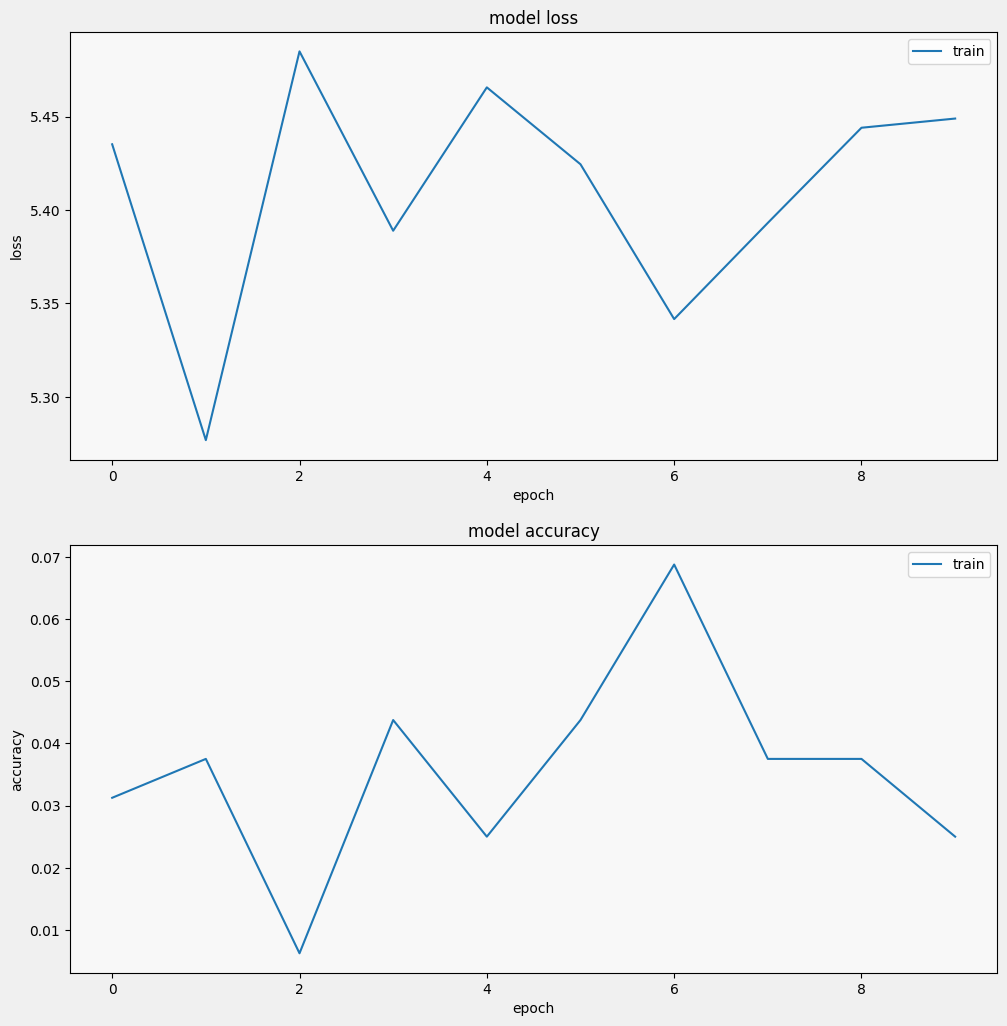

In [ ]:
NN = nn_generator_lookup[False][False](load_weights=True)
loss, accuracy = NN.evaluate(validation_generator_lookup[False])
print('loss: ', loss)
print('accuracy: ', accuracy)


# We will display the loss of the model for each epoch
def display_training_curves(training, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train'])

display_training_curves(history.history['loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], 'accuracy', 212)


Validation for BaseLine CNN for Caltech 256

Neural Network Model created
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 8)       224       
                                                                 
 conv2d_31 (Conv2D)          (None, 220, 220, 8)       584       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 110, 110, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 108, 108, 16)      1168      
                                                                 
 conv2d_33 (Conv2D)          (None, 106, 106, 16)      2320      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 53, 53, 16)       0         
 g2D)                    

<ipython-input-9-ff55632accee>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


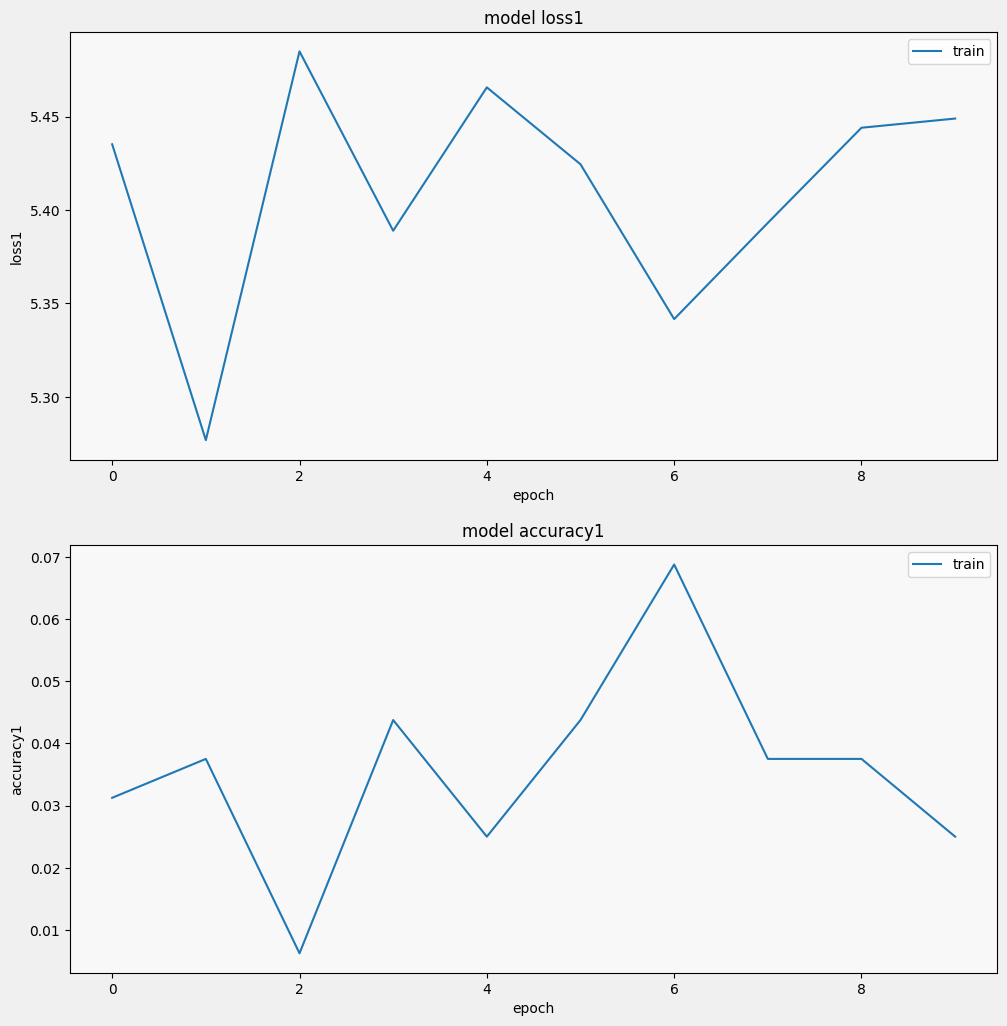

In [ ]:
NN = nn_generator_lookup[False][True](load_weights=True)
loss1, accuracy1 = NN.evaluate(validation_generator_lookup[True])
print('loss: ', loss1)
print('accuracy: ', accuracy1)

# We will display the loss of the model for each epoch
def display_training_curves(training, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train'])

display_training_curves(history.history['loss'], 'loss1', 211)
display_training_curves(history.history['accuracy'], 'accuracy1', 212)


Validation for VGG16 CNN for Caltech 20

In [ ]:
NN = nn_generator_lookup[True][False](load_weights=True)
loss, accuracy = NN.evaluate(validation_generator_lookup[False])
print('loss: ', loss)
print('accuracy: ', accuracy)

Neural Network Model created
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_37 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_39 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                    

Validation For VGG16 CNN for Caltech 256

In [ ]:
NN = nn_generator_lookup[True][True](load_weights=True)
loss, accuracy = NN.evaluate(validation_generator_lookup[True])
print('loss: ', loss)
print('accuracy: ', accuracy)

Neural Network Model created
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_49 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_51 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                    